# 3. Deep Ritz Method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [2]:
device = torch.device('cuda:1')

# 3.1 The Poisson equation in two dimension

<p style='font-size:18px; line-height:2.5em'> Consider the Poisson equation : \begin{eqnarray} -\Delta u =& 0 &&\text{ for } x \in (0,1)^2, \\ u=&xy &&\text{ for } x \in \partial(0,1)^2. \end{eqnarray} Then the solution is simply $u(x,y) = xy$
    
<p style='font-size:18px; line-height:2.5em'> The loss function is given by \begin{equation} \int_{(0,1)^2} \frac{1}{2} |\nabla u_{nn}|^2 dxdy + \beta \cdot \int_{\partial (0,1)^2} (u_{nn}(x,y) - xy)^2 dxdy. \end{equation} 

# Dataset generation

In [3]:
Nx = 50                                                   # Number of samples
Ny = 50                                                   # Number of samples
x = torch.linspace(-1, 1, Nx)                             # Input data for x (N x 1)
y = torch.linspace(-1, 1, Ny)                             # Input data for y (N x 1)

xy = torch.meshgrid(x,y)
xy_grid = torch.cat([xy[0].reshape(-1,1), xy[1].reshape(-1,1)],dim=1)

x_bdry = xy_grid[torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0))]
y_bdry = xy_grid[torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0))]
xy_bdry = torch.cat([x_bdry, y_bdry])
u_bdry = (xy_bdry[:,0]*xy_bdry[:,1]).view(-1,1)

#is_bdry = torch.logical_or(torch.logical_or((xy_grid[:,0]==1), (xy_grid[:,0]==0)), torch.logical_or((xy_grid[:,1]==1), (xy_grid[:,1]==0)))

/opt/ohpc/pub/python/3.11.2/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [4]:
eps = 0.2
is_bdry = 1-torch.min(torch.abs(xy_grid[:,0]**2+xy_grid[:,1]**2-1), eps*torch.ones(xy_grid[:,0].shape))/eps
is_domain = torch.abs(xy_grid[:,0]**2+xy_grid[:,1]**2-1)<=eps

In [5]:
eps = 0.05
is_bdry = torch.min(torch.stack([xy_grid[:,0]+1, -xy_grid[:,0]+1,xy_grid[:,1]+1, -xy_grid[:,1]+1]), dim=0).values
is_bdry = (1-is_bdry)*(is_bdry<eps)
is_domain = torch.ones(xy_grid.shape)

In [6]:
is_bdry

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [7]:
xy_grid[:,0].unsqueeze(0)

tensor([[-1., -1., -1.,  ...,  1.,  1.,  1.]])

In [26]:
torch.cat(xy_grid[:,0]+1, -xy_grid[:,0]+1,xy_grid[:,1]+1, -xy_grid[:,1]+1).shape

TypeError: cat() received an invalid combination of arguments - got (Tensor, Tensor, Tensor, Tensor), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
      didn't match because some of the arguments have invalid types: (!Tensor!, !Tensor!, !Tensor!, Tensor)
 * (tuple of Tensors tensors, name dim, *, Tensor out)
      didn't match because some of the arguments have invalid types: (!Tensor!, !Tensor!, !Tensor!, Tensor)


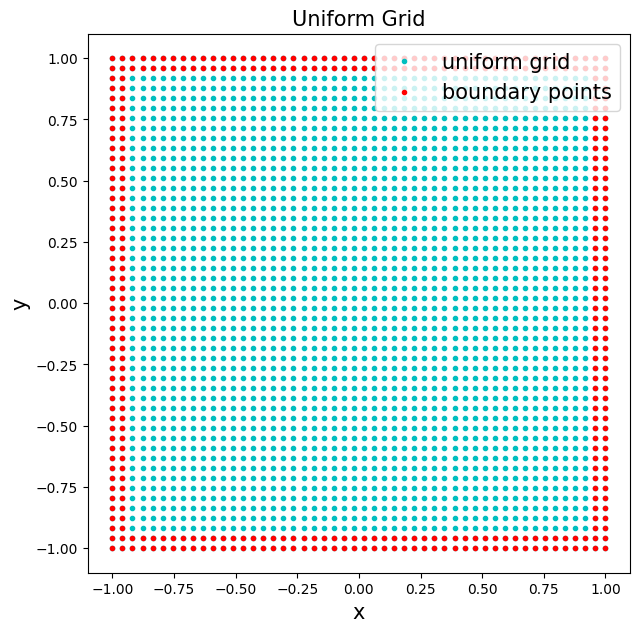

In [8]:
plt.figure(figsize=(7,7))
plt.plot(xy_grid[:,0], xy_grid[:,1], 'co', markersize=3, label='uniform grid')
#plt.plot(xy_bdry[:,0], xy_bdry[:,1], 'ro', markersize=3, label='boundary points')
plt.plot(xy_grid[:,0][is_bdry>0.5], xy_grid[:,1][is_bdry>0.5], 'ro', markersize=3, label='boundary points')
plt.legend(loc='upper right', fontsize=15)
plt.title('Uniform Grid', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.savefig('drm_data')

In [7]:
np.where(is_bdry>0.98)

(array([  23,   24,   25,   26,  211,  238,  554,  595, 1150, 1199, 1200,
        1249, 1250, 1299, 1300, 1349, 1904, 1945, 2261, 2288, 2473, 2474,
        2475, 2476]),)

# Neural Network

In [9]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.Tanh()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

# Loss function, Optimizer

In [10]:
# Prepare for training

network = model(hidden_dims=[2,10,10,10,1]).to(device)       # Pass the network to GPU
xy_grid = xy_grid.to(device).requires_grad_(True)            # Pass data to GPU
xy_bdry = xy_bdry.to(device)                                 # Pass data to GPU
u_bdry = u_bdry.to(device)
is_bdry = is_bdry.to(device)
x, y = x.to(device), y.to(device)
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 20000                                         # Number of Training Iterations

In [11]:
is_bdry.shape

torch.Size([2500])

# Compute $\frac{dy}{dt}$

In [12]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

# Training

In [13]:
# Train
beta = 500
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    output = network(xy_grid)
    #output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy_grid)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) 
    integrand_bdry = ((output.squeeze()-xy_grid[:,0]*xy_grid[:,1])*is_bdry)**2
    #integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()#torch.trapz(torch.trapz(integrand.view(Nx,Ny), x), y) 
    loss_bdry = integrand_bdry.sum() * (1/is_bdry.sum())
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :    100/ 20000 | Loss_ge : 0.0653150 | Loss_bdry : 0.1299930
EPOCH :    200/ 20000 | Loss_ge : 0.3493570 | Loss_bdry : 0.0075976
EPOCH :    300/ 20000 | Loss_ge : 0.3818198 | Loss_bdry : 0.0047361
EPOCH :    400/ 20000 | Loss_ge : 0.3742169 | Loss_bdry : 0.0037088
EPOCH :    500/ 20000 | Loss_ge : 0.3672163 | Loss_bdry : 0.0029629
EPOCH :    600/ 20000 | Loss_ge : 0.3619978 | Loss_bdry : 0.0024156
EPOCH :    700/ 20000 | Loss_ge : 0.3586324 | Loss_bdry : 0.0020315
EPOCH :    800/ 20000 | Loss_ge : 0.3567049 | Loss_bdry : 0.0017723
EPOCH :    900/ 20000 | Loss_ge : 0.3556783 | Loss_bdry : 0.0015990
EPOCH :   1000/ 20000 | Loss_ge : 0.3551073 | Loss_bdry : 0.0014794
EPOCH :   1100/ 20000 | Loss_ge : 0.3547057 | Loss_bdry : 0.0013911
EPOCH :   1200/ 20000 | Loss_ge : 0.3543249 | Loss_bdry : 0.0013202
EPOCH :   1300/ 20000 | Loss_ge : 0.3539042 | Loss_bdry : 0.0012589
EPOCH :   1400/ 20000 | Loss_ge : 0.3534307 | Loss_bdry : 0.0012029
EPOCH :   1500/ 20000 | Loss_ge : 0.3529099 | Lo

In [9]:
integrand_bdry

NameError: name 'integrand_bdry' is not defined

In [27]:
is_bdry.shape

torch.Size([2500])

In [18]:
xy_grid.shape

torch.Size([2500, 2])

In [9]:
torch.save(network, 'DRM_d=2.pt')
network = torch.load('DRM_d=2.pt', map_location=device)

In [14]:
true = (xy_grid[:,0]*xy_grid[:,1]).view(-1,1)
pred = network(xy_grid)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred.cpu()*is_domain, true.cpu()*is_domain).item())

Mean Square Error is : 0.0000149


# 3.2 The Poisson equation in high dimension

<p style='font-size:18px; line-height:2.5em'> Consider the Poisson equation : 
    \begin{eqnarray} -\Delta u =&0  &&\text{ for } x \in (0,1)^{10}, \\ u =& \sum_{i=1}^{5} x_{2i-1}x_{2i} && \text{ for } x \in \partial(0,1)^{10}. \end{eqnarray} Then the solution is simply $u(x,y) = xy$
    
<p style='font-size:18px; line-height:2.5em'> The loss function is given by \begin{equation} \int_{(0,1)^{10}} \frac{1}{2} |\nabla u_{nn}|^2 dx + \beta \cdot \int_{\partial (0,1)^{10}} (u_{nn} - \sum_{i=1}^{5} x_{2i-1}x_{2i})^2 dx. \end{equation} 

In [11]:
def sample(N, dim):
    return torch.rand([N,dim])

def sample_bdry(N, dim):
    N = int(N/2)
    interior = torch.rand([N,dim])
    ind = int(N/dim)
    for i in range(dim) :
        interior[i*ind:(i+1)*ind, i] = 0
    interior[(ind)*dim:, -1] = 0
    
    interior2 = torch.rand([N,dim])
    ind = int(N/dim)
    for i in range(dim) :
        interior2[i*ind:(i+1)*ind, i] = 1
    interior2[ind*dim:, -1] = 1
    
    return torch.cat([interior, interior2])

def bdry_label(bdry_data) :
    return sum(bdry_data[:,2*i]*bdry_data[:,2*i+1] for i in range(5)).view(-1,1)
        

In [12]:
# Build a neural network

class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = [nn.Linear(hidden_dims[0], hidden_dims[1])]
        for i in range(1,len(hidden_dims)-2) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1])) # hidden layers
        self.layers.append(nn.Linear(hidden_dims[i+1], hidden_dims[-1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :                       # Weight initialization
            nn.init.xavier_uniform_(layer.weight)        # Also known as Glorot initialization
        
        self.act = nn.Tanh()
    
    def forward(self, x) :
        x = self.act(self.layers[0](x))
        for layer in self.layers[1:-1] :
            y = self.act(layer(x))
            x = self.act(layer(y)) + x
        x = self.layers[-1](x)
        return x

In [13]:
# Prepare for training

network = model(hidden_dims=[10,10,10,10,1]).to(device)       # Pass the network to GPU
loss_f = nn.MSELoss()                                  # Mean Square Error loss function
optimizer = optim.Adam(network.parameters(), lr=1e-3)  # Adam optimizer
EPOCHS = 50000                                         # Number of Training Iterations

In [14]:
# Train
beta = 500
N = 1000
loss_list = []
network.train()

for i in range(1, EPOCHS+1) :
    optimizer.zero_grad()
    # Data generation
    xy = sample(N, dim=10).to(device).requires_grad_(True)
    xy_bdry = sample_bdry(N, dim=10).to(device)
    u_bdry = bdry_label(xy_bdry)
    
    # Forward
    output = network(xy)
    output_bdry = network(xy_bdry)
    grad_output = derivative(output, xy)
    
    integrand = 0.5*torch.pow(torch.norm(grad_output, dim=1), 2).view(-1,1) 
    integrand_bdry = (output_bdry-u_bdry)**2
    
    loss_ge = integrand.mean()
    loss_bdry = integrand_bdry.mean()
    
    loss = loss_ge + beta * loss_bdry
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if not i % 100 :
        print('EPOCH : %6d/%6d | Loss_ge : %8.7f | Loss_bdry : %8.7f' %(i, EPOCHS, loss_ge.item(), loss_bdry.item()))
        #clear_output(wait=True)
print('Training Finished.')

EPOCH :    100/ 50000 | Loss_ge : 0.6191313 | Loss_bdry : 0.2723666
EPOCH :    200/ 50000 | Loss_ge : 0.6829243 | Loss_bdry : 0.1504076
EPOCH :    300/ 50000 | Loss_ge : 1.1060153 | Loss_bdry : 0.0796755
EPOCH :    400/ 50000 | Loss_ge : 1.3070325 | Loss_bdry : 0.0561458
EPOCH :    500/ 50000 | Loss_ge : 1.3423624 | Loss_bdry : 0.0495636
EPOCH :    600/ 50000 | Loss_ge : 1.3519357 | Loss_bdry : 0.0430463
EPOCH :    700/ 50000 | Loss_ge : 1.3871516 | Loss_bdry : 0.0401189
EPOCH :    800/ 50000 | Loss_ge : 1.4003665 | Loss_bdry : 0.0404189
EPOCH :    900/ 50000 | Loss_ge : 1.4165384 | Loss_bdry : 0.0339335
EPOCH :   1000/ 50000 | Loss_ge : 1.4347850 | Loss_bdry : 0.0327782
EPOCH :   1100/ 50000 | Loss_ge : 1.4369739 | Loss_bdry : 0.0310929
EPOCH :   1200/ 50000 | Loss_ge : 1.4431155 | Loss_bdry : 0.0279188
EPOCH :   1300/ 50000 | Loss_ge : 1.4645944 | Loss_bdry : 0.0287026
EPOCH :   1400/ 50000 | Loss_ge : 1.5221541 | Loss_bdry : 0.0234554
EPOCH :   1500/ 50000 | Loss_ge : 1.5036019 | Lo

EPOCH :  24300/ 50000 | Loss_ge : 1.6046373 | Loss_bdry : 0.0006290
EPOCH :  24400/ 50000 | Loss_ge : 1.6109011 | Loss_bdry : 0.0007904
EPOCH :  24500/ 50000 | Loss_ge : 1.6070663 | Loss_bdry : 0.0006312
EPOCH :  24600/ 50000 | Loss_ge : 1.6097393 | Loss_bdry : 0.0006179
EPOCH :  24700/ 50000 | Loss_ge : 1.6048702 | Loss_bdry : 0.0005229
EPOCH :  24800/ 50000 | Loss_ge : 1.5828264 | Loss_bdry : 0.0005748
EPOCH :  24900/ 50000 | Loss_ge : 1.5879569 | Loss_bdry : 0.0005915
EPOCH :  25000/ 50000 | Loss_ge : 1.6336669 | Loss_bdry : 0.0005261
EPOCH :  25100/ 50000 | Loss_ge : 1.6179346 | Loss_bdry : 0.0005567
EPOCH :  25200/ 50000 | Loss_ge : 1.6382039 | Loss_bdry : 0.0006305
EPOCH :  25300/ 50000 | Loss_ge : 1.6204958 | Loss_bdry : 0.0005098
EPOCH :  25400/ 50000 | Loss_ge : 1.5993624 | Loss_bdry : 0.0007626
EPOCH :  25500/ 50000 | Loss_ge : 1.5886863 | Loss_bdry : 0.0008572
EPOCH :  25600/ 50000 | Loss_ge : 1.6070273 | Loss_bdry : 0.0005346
EPOCH :  25700/ 50000 | Loss_ge : 1.6109642 | Lo

EPOCH :  36400/ 50000 | Loss_ge : 1.5999154 | Loss_bdry : 0.0003112
EPOCH :  36500/ 50000 | Loss_ge : 1.5950119 | Loss_bdry : 0.0003079
EPOCH :  36600/ 50000 | Loss_ge : 1.5655379 | Loss_bdry : 0.0006761
EPOCH :  36700/ 50000 | Loss_ge : 1.6121736 | Loss_bdry : 0.0003429
EPOCH :  36800/ 50000 | Loss_ge : 1.5862491 | Loss_bdry : 0.0003433
EPOCH :  36900/ 50000 | Loss_ge : 1.6376947 | Loss_bdry : 0.0002655
EPOCH :  37000/ 50000 | Loss_ge : 1.5978107 | Loss_bdry : 0.0003082
EPOCH :  37100/ 50000 | Loss_ge : 1.6218231 | Loss_bdry : 0.0004942
EPOCH :  37200/ 50000 | Loss_ge : 1.6023999 | Loss_bdry : 0.0003201
EPOCH :  37300/ 50000 | Loss_ge : 1.6203089 | Loss_bdry : 0.0004352
EPOCH :  37400/ 50000 | Loss_ge : 1.6065394 | Loss_bdry : 0.0004076
EPOCH :  37500/ 50000 | Loss_ge : 1.6225909 | Loss_bdry : 0.0003053
EPOCH :  37600/ 50000 | Loss_ge : 1.6110429 | Loss_bdry : 0.0004197
EPOCH :  37700/ 50000 | Loss_ge : 1.6119465 | Loss_bdry : 0.0003463
EPOCH :  37800/ 50000 | Loss_ge : 1.6043059 | Lo

EPOCH :  48500/ 50000 | Loss_ge : 1.6211164 | Loss_bdry : 0.0002734
EPOCH :  48600/ 50000 | Loss_ge : 1.6166395 | Loss_bdry : 0.0002276
EPOCH :  48700/ 50000 | Loss_ge : 1.6149644 | Loss_bdry : 0.0005133
EPOCH :  48800/ 50000 | Loss_ge : 1.6182814 | Loss_bdry : 0.0002465
EPOCH :  48900/ 50000 | Loss_ge : 1.6147496 | Loss_bdry : 0.0002623
EPOCH :  49000/ 50000 | Loss_ge : 1.5934904 | Loss_bdry : 0.0004246
EPOCH :  49100/ 50000 | Loss_ge : 1.6122622 | Loss_bdry : 0.0002638
EPOCH :  49200/ 50000 | Loss_ge : 1.6167060 | Loss_bdry : 0.0002407
EPOCH :  49300/ 50000 | Loss_ge : 1.6071073 | Loss_bdry : 0.0002338
EPOCH :  49400/ 50000 | Loss_ge : 1.6192372 | Loss_bdry : 0.0002401
EPOCH :  49500/ 50000 | Loss_ge : 1.6280258 | Loss_bdry : 0.0002283
EPOCH :  49600/ 50000 | Loss_ge : 1.6349996 | Loss_bdry : 0.0002357
EPOCH :  49700/ 50000 | Loss_ge : 1.6246202 | Loss_bdry : 0.0002466
EPOCH :  49800/ 50000 | Loss_ge : 1.6139954 | Loss_bdry : 0.0002657
EPOCH :  49900/ 50000 | Loss_ge : 1.5948963 | Lo

In [16]:
torch.save(network, 'DRM_d=10.pt')
#network = torch.load('DRM_d=10.pt', map_location=device)

In [17]:
xy = sample(10000, dim=10).to(device)
true = bdry_label(xy)
pred = network(xy)

print('Mean Square Error is : %8.7f' % F.mse_loss(pred, true).item())

Mean Square Error is : 0.0002006
